In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from zonolayer import Zonolayer

In [2]:
class CentreNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, latent_dim=5):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
        )
        self.output_layer = nn.Linear(latent_dim, 1)

    def forward(self, x, return_latent=False):
        latent = self.feature_net(x)
        y = self.output_layer(latent)
        if return_latent:
            return y, latent
        return y

# 2. Generate synthetic data


def nonlinear_data(n):
    n_samples = n
    x = np.random.rand(n_samples)
    w = np.random.normal(0, 0.025, n_samples)
    y = 0.3 * (15 * x * np.exp(-3 * x) + w * x)
    y_radius = (1/160) * (np.abs(x - 2) + 0.5)
    y_lower = y - y_radius
    y_upper = y + y_radius

    x_grid = np.linspace(0, 10, n_samples)

    return n_samples, x, y, y_lower, y_upper, x_grid


n, x, y, y_lower, y_upper, x_grid = nonlinear_data(1250)

# Tensor conversion for PyTorch
y_lb_t = torch.tensor(y_lower, dtype=torch.float32).unsqueeze(1)
y_ub_t = torch.tensor(y_upper, dtype=torch.float32).unsqueeze(1)
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# 3. Train the centre network on the midpoints of the intervals to fit a regression line


def train_centre(x_t, y_lb_t, y_ub_t, epochs=200, lr=1e-3, batch_size=64, print_every=20):
    y_mid = 0.5 * (y_lb_t + y_ub_t)  # midpoints

    centre_net = CentreNet(input_dim=x_t.shape[1])
    optimizer = torch.optim.Adam(centre_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    n_samples = x_t.shape[0]

    for epoch in range(epochs):
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0
        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            xb = x_t[idx]
            yb = y_mid[idx]

            pred = centre_net(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(xb)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}: MSE = {epoch_loss / n_samples:.6f}")

    return centre_net


centre_net = train_centre(x_t, y_lb_t, y_ub_t)

Epoch 20: MSE = 0.008222
Epoch 40: MSE = 0.000652
Epoch 60: MSE = 0.000148
Epoch 80: MSE = 0.000086
Epoch 100: MSE = 0.000061
Epoch 120: MSE = 0.000044
Epoch 140: MSE = 0.000037
Epoch 160: MSE = 0.000028
Epoch 180: MSE = 0.000038
Epoch 200: MSE = 0.000043


In [5]:
# Test points
test_set = torch.linspace(x_t.min(), x_t.max(), n).unsqueeze(1)

zl = Zonolayer(centre_net, lambda_reg=1e-4, alpha=0.05)
results, ipm_lower, ipm_upper = zl.compute(x_t, test_set, y_lower, y_upper, ipm=True)

# Unpack results
y_lower_pred = results["y_lower_pred"]
y_upper_pred = results["y_upper_pred"]
pi_lower = results["pi_lower"]
pi_upper = results["pi_upper"]
centre_pred = results["pred_centre"]

     pcost       dcost       gap    pres   dres   k/t
 0:  5.5511e-17  1.0947e-13  5e+03  2e+00  3e+03  1e+00
 1:  4.6350e-01  3.8299e-01  1e+02  2e-01  2e+02  3e-03
 2:  1.0316e-01  1.0201e-01  2e+00  1e-02  1e+01  5e-03
 3:  6.2854e-02  6.2634e-02  3e-01  5e-03  5e+00  2e-03
 4:  6.8570e-02  6.8467e-02  4e-01  5e-03  5e+00  2e-03
 5:  5.8534e-02  5.8478e-02  2e-01  3e-03  3e+00  1e-03
 6:  6.4385e-02  6.4337e-02  2e-01  4e-03  4e+00  1e-03
 7:  5.9993e-02  5.9982e-02  1e-01  2e-03  2e+00  7e-04
 8:  5.9252e-02  5.9128e-02  7e-02  1e-03  1e+00  4e-04
 9:  5.7669e-02  5.7617e-02  1e-02  2e-04  2e-01  2e-05
10:  5.7359e-02  5.7316e-02  7e-03  1e-04  1e-01  8e-06
11:  5.7356e-02  5.7314e-02  7e-03  1e-04  1e-01  6e-06
12:  5.7156e-02  5.7144e-02  2e-03  3e-05  3e-02  1e-06
13:  5.7161e-02  5.7150e-02  2e-03  3e-05  3e-02  1e-06
14:  5.7153e-02  5.7149e-02  6e-04  1e-05  1e-02  2e-07
15:  5.7153e-02  5.7152e-02  8e-05  1e-06  1e-03  2e-08
16:  5.7153e-02  5.7153e-02  3e-06  5e-08  5e-05  

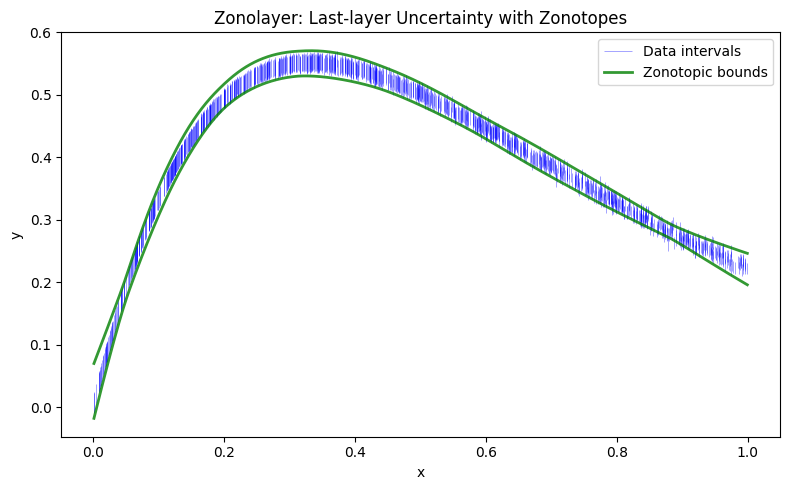

In [10]:
x_plot = np.linspace(x_t.min(), x_t.max(), n)

plt.figure(figsize=(8, 5))

x_sorted, idx = torch.sort(x_t, dim=0)
y_lb_sorted = y_lb_t[idx]
y_ub_sorted = y_ub_t[idx]

plt.vlines(x_sorted.numpy().flatten(),
           y_lb_sorted.numpy().flatten(),
           y_ub_sorted.numpy().flatten(),
           color='blue', alpha=.5, linewidth=0.5,
           label='Data intervals')

# Plot NN prediction
#plt.plot(x_plot.numpy(), centre_pred, color='green', lw=1.5, label='NN prediction', zorder=5)

plt.plot(x_plot.numpy(), y_lower_pred, 'g', lw=2, label='Zonotopic bounds', alpha=0.8)
plt.plot(x_plot.numpy(), y_upper_pred, 'g', lw=2, label='__nolegend__', alpha=0.8)

#plt.fill_between(x_plot.numpy(), y_lower_pred, y_upper_pred, color='red', alpha=0.3, label='Zonotope expectation band')

#plt.plot(x_plot.numpy(), ipm_lower, 'black', lw=2, label='IPM bounds', alpha=0.8)
#plt.plot(x_plot.numpy(), ipm_upper, 'black', lw=2, label='__nolegend__', alpha=0.8)


plt.legend()
plt.title("Zonolayer: Last-layer Uncertainty with Zonotopes")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()